## Forecast the number of clients using WoodGreen’s mental health and community health services weekly.

#### Import neccessary libraries 

In [41]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


#### Load and Inspect columns from WoodGreen datasets

In [42]:
# Define the file path 
file_path = "../../woodgreen-data/WoodGreen_All_Systems.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display basic information about the DataFrame
print(f"Total rows: {len(df)}")
print(f"Total columns: {len(df.columns)}")

# Print all column names
columns_list = df.columns.tolist()
print("\n--- COLUMN NAMES ---")
for col in columns_list:
    print(col)

/var/folders/3s/j5qq7fvd5jn_tvdy41sw66bm0000gn/T/ipykernel_82849/1572946015.py:5: DtypeWarning: Columns (0,3,4,9,12,15,16,21,22,26,27,31,33,34,40,41,42,43,46,47,48,49,50,51,52,54,55,56,57,58,59,61,62,63,64,65,66,67,69,73,74,75,76,77,78,79,81,82,84,85,86,87,88,90,91,92,93,94,95,96,97,98,99,100,101,102,104,106,107,111,113,114,115,117,126,127,133,135,137,144,146,148,149,152,153,154,155,157,158,159,160,162,164,165,166,167,168,171,172,173,174,175,176,178,179,180,181,182,183,184,185,186,187) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Total rows: 149557
Total columns: 188

--- COLUMN NAMES ---
Unique Record ID
Surname
First Given Name
Sex
Marital Status
Birth Date (YYMMDD)
Year of Birth
Month of Birth
Day of Birth
Birth Province / Country Code
Social Insurance Number
Provincial Health Insurance Number
Home Province Code
Home Address
Home Address Postal Code
Creation Date
Last Modified
System Registration
emailaddress1_DC
statecode_DC
mir_primary_phone_DC
modifiedon_DC
employmentstatus_DC
mir_workwithanyemployer_DC
mir_looking_for_work_DC
crmd_canadianexperience_DC
work_experience_DC
years_of_work_experience_DC
mir_minimum_one_year_experience_DC
mir_history_of_poor_work_retention_DC
mir_labor_market_change_DC
time_out_of_school_work_training_DC
mir_internationallytrainedprofessionals_DC
internationallytrainedtype_DC
primaryincomesource_DC
mir_lowincome_DC
mir_individual_monthly_income_after_tax_DC
mir_family_income_per_year_after_tax_DC
mir_low_income_cut_off_licos_after_tax_DC
statuscode_DC
program_startdate_DC
prog

#### View the list of the program names

In [64]:
print(df['Program_CU'].unique())

[nan 'SIL' 'Developmental Services' 'APSW' 'APSW Housing'
 'Counselling and Support Services' 'Albany Drop-In Clinic - CSS'
 'CSS ï¿½ Gerstein' 'CSS ï¿½ SCOPE' 'Case Management' 'Counselling'
 'Social Work Drop-In Clinic - CSS' 'Homelessness & Housing help'
 'Crisis Services' 'Behaviour Support' 'Street to Home'
 'Transitional Care Coordination'
 'Transitional Care Coordination - Senior' 'Walk-In Counseling'
 'First Step to Home' 'First Step to Home - Follow Up' 'Full Circle'
 'Full Circle - Seniors Crisis' 'Social Work - Cluster'
 'Social Work Drop-In Clinic - FC' 'Social Work - Seniors Crisis'
 'Social Work Drop-In Clinic - SW' 'Social Work'
 'Albany Drop-In Clinic - SW' 'Social Work - Slaight'
 'Social Work - Group' 'Social Work Drop-In Clinic - Slaight' 'Oakridge'
 'Caregiver Support' 'High Intensity Supports (Caregiver Support)'
 'Caregiver Support ï¿½ Info and Referrals' 'Caregiver Support ï¿½ Group'
 'Albany clinic - CGSW' 'CAMH- Psychotherapy' 'Assess and Restore'
 'Social Work

In [43]:
# View the list of the program names 
print(df['program_name_DC'].head(10))

# Check how many non-null entries exist
print("\nNon-null count:", df['program_name_DC'].notna().sum())

# Get a list of unique program names (to understand what's inside)
unique_programs = df['program_name_DC'].dropna().unique()
print("\nNumber of unique programs:", len(unique_programs))

# Print first few unique names
print("\nSample unique program names:")
print(unique_programs)  


0    Tax Clinic
1    Tax Clinic
2    Tax Clinic
3    Tax Clinic
4    Tax Clinic
5    Tax Clinic
6    Tax Clinic
7    Tax Clinic
8    Tax Clinic
9    Tax Clinic
Name: program_name_DC, dtype: object

Non-null count: 41573

Number of unique programs: 37

Sample unique program names:
['Tax Clinic' 'Family Newcomer Services' 'Family Finance Clinic'
 'Financial Empowerment Counselling' 'Employment Ontario'
 'Financial Empowerment Library Project'
 'Community Connections - Group Activities'
 'Newcomer Settlement and Integration Services (Newcomer Services Program)'
 'NSP Youth Program' 'Newcomer Community Integration Program (NCIP)'
 'Visual Effects Compositing Program' 'Asylum Integration Program (AIP)'
 'Enhanced Language Training' 'Youth Wellness Centre'
 'Youth Housing Navigation and Subsidy Support Program'
 'Youth Job Connections Summer (YJC Summer)' 'Newcomer Youth Service'
 'Community Connections - Mentorship' 'Rites of Passage'
 'Youth Job Connections (YJC)' 'Employment Accessibility

### Filter the dataset by 
- Youth Wellness Center
- Rites of Passage
- Community Connections - Group Activities
- Community Connections - Mentorship
- Intensive Case Management for Youth (ICM)

In [44]:
# Define the relevant programs
mental_health_programs = [
    'Youth Wellness Centre',
    'Rites of Passage',
    'Community Connections - Group Activities',
    'Community Connections - Mentorship',
    'Intensive Case Management for Youth (ICM)'
]

# Filter dataset
df_filtered = df[df['program_name_DC'].isin(mental_health_programs)].copy()

# Check how many records remain
print("Filtered dataset size:", df_filtered.shape)


Filtered dataset size: (1209, 188)


#### Filter the records by valid start date

In [45]:
# Filter mental health programs and create a copy
df_mental = df[df['program_name_DC'].isin(mental_health_programs)].copy()

# Try multiple possible date columns
date_columns = ['Client Intake Date_AC', 'program_startdate_DC', 'Start Date_AC', 'Service Start Date_CC']

# Find which column has valid dates
for col in date_columns:
    df_mental['intake_date'] = pd.to_datetime(df_mental[col], errors='coerce')
    valid_count = df_mental['intake_date'].notna().sum()
    print(f"{col}: {valid_count} valid dates")

# Choose the column with the most valid dates
df_mental['intake_date'] = pd.to_datetime(df_mental['program_startdate_DC'], errors='coerce')  # Example

# Inspect
print("Number of records with valid intake dates:", df_mental['intake_date'].notna().sum())
print("Earliest intake date:", df_mental['intake_date'].min())
print("Latest intake date:", df_mental['intake_date'].max())
print("\nRecord count per year:")
print(df_mental['intake_date'].dt.year.value_counts().sort_index())

Client Intake Date_AC: 0 valid dates
program_startdate_DC: 1209 valid dates
Start Date_AC: 0 valid dates
Service Start Date_CC: 0 valid dates
Number of records with valid intake dates: 1209
Earliest intake date: 2024-07-15 00:00:00
Latest intake date: 2025-10-17 00:00:00

Record count per year:
intake_date
2024    585
2025    624
Name: count, dtype: int64


#### Visualize how many clients are registered in each mental/community health program.

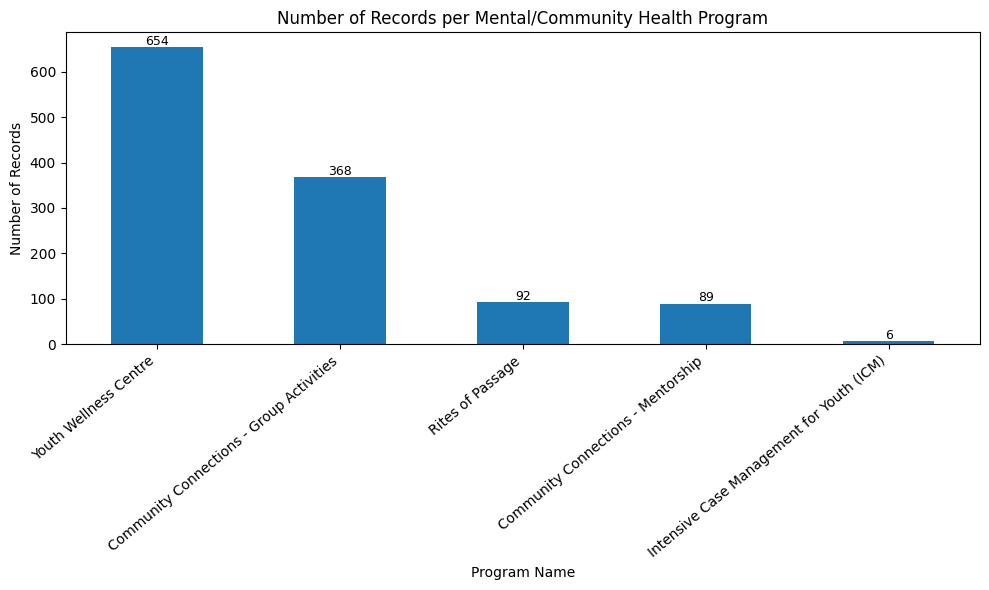

In [46]:
# Count how many records per program
program_counts = df_filtered['program_name_DC'].value_counts()

# Plot bar chart
plt.figure(figsize=(10, 6))
program_counts.plot(kind='bar')

# Add labels and title
plt.title('Number of Records per Mental/Community Health Program')
plt.xlabel('Program Name')
plt.ylabel('Number of Records')
plt.xticks(rotation=40, ha='right')

# Add value labels on top of bars
for i, v in enumerate(program_counts):
    plt.text(i, v + 5, str(v), ha='center', fontsize=9)

plt.tight_layout()
plt.show()


#### Visualize the number of intake per year (2024-2025)

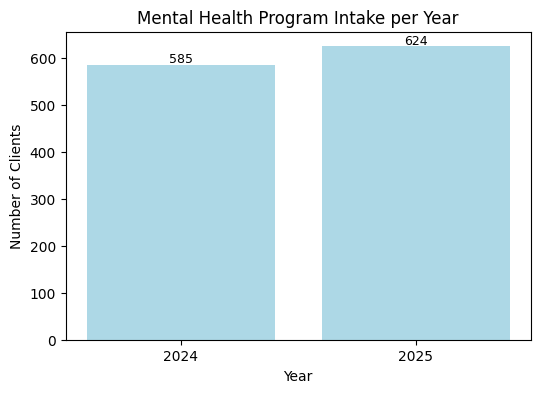

In [47]:
# Count per year
yearly_counts = df_mental['intake_date'].dt.year.value_counts().sort_index()

# Plot
plt.figure(figsize=(6,4))
plt.bar(yearly_counts.index.astype(str), yearly_counts.values, color='lightblue')
plt.title('Mental Health Program Intake per Year')
plt.xlabel('Year')
plt.ylabel('Number of Clients')
# Add value labels on top of bars
for i, v in enumerate(yearly_counts.values):
    plt.text(i, v + 5, str(v), ha='center', fontsize=9)
plt.show()

#### Visualize the number of intake per month (July-2024 to Oct-2025)

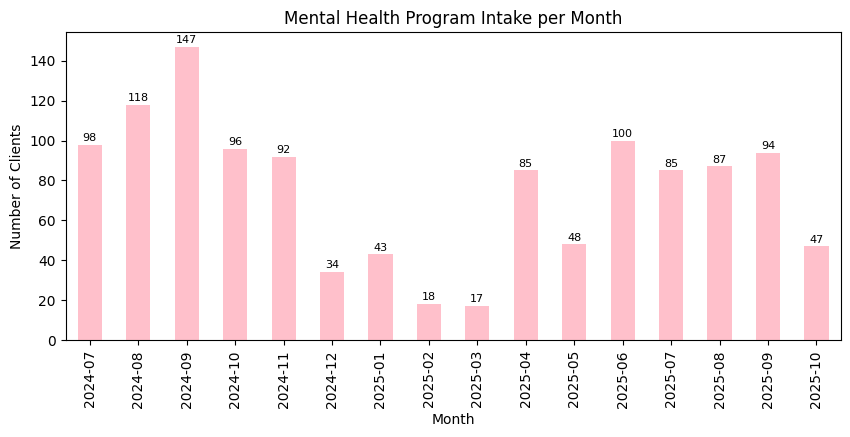

In [48]:
monthly_counts = df_mental['intake_date'].dt.to_period('M').value_counts().sort_index()

plt.figure(figsize=(10,4))
monthly_counts.plot(kind='bar', color='pink')
plt.title('Mental Health Program Intake per Month')
plt.xlabel('Month')
plt.ylabel('Number of Clients')
# Add value labels on top of bars
for i, v in enumerate(monthly_counts.values):
    plt.text(i, v + 2, str(v), ha='center', fontsize=8)
plt.show()

#### Visualize the number of intake per week (July-2024 to Oct-2025)

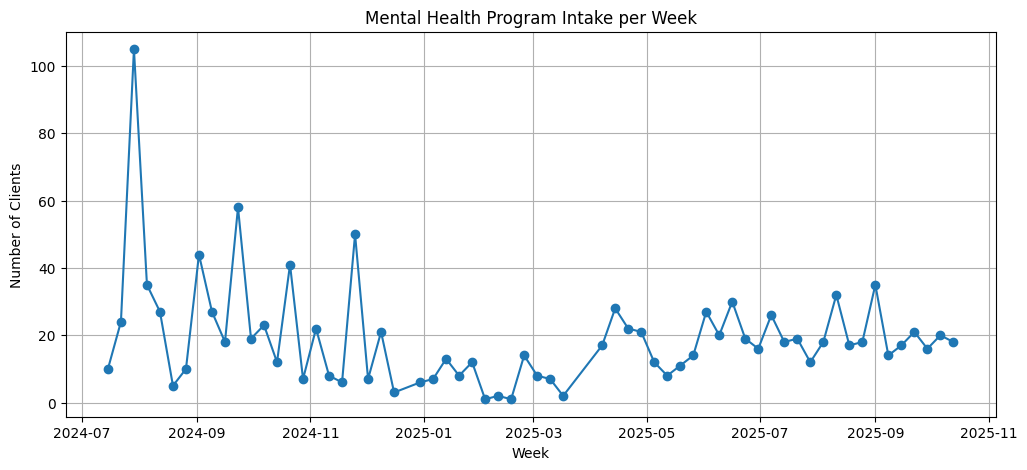

In [49]:
# Aggregate weekly
weekly_counts = df_mental['intake_date'].dt.to_period('W').value_counts().sort_index()

# Convert PeriodIndex to datetime for plotting
weekly_counts.index = weekly_counts.index.to_timestamp()

# Plot weekly trend
plt.figure(figsize=(12,5))
plt.plot(weekly_counts.index, weekly_counts.values, marker='o', linestyle='-')
plt.title('Mental Health Program Intake per Week')
plt.xlabel('Week')
plt.ylabel('Number of Clients')
plt.grid(True)
plt.show()


#### Visualize the number of intake based on gender per year

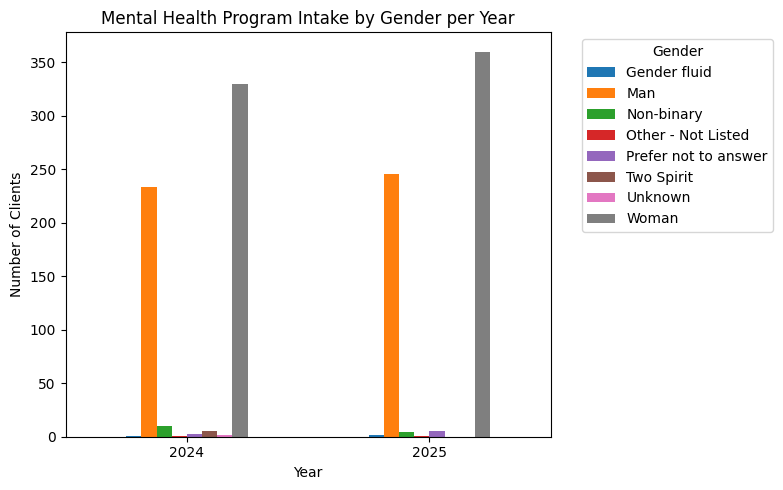

In [ ]:
# Count number of intakes per Year and Sex 
df_mental['Year'] = df_mental['intake_date'].dt.year
yearly_gender_counts = df_mental.groupby(['Year', 'Sex']).size().unstack(fill_value=0)

# Plot all gender categories
yearly_gender_counts.plot(kind='bar', figsize=(8,5))
plt.title('Mental Health Program Intake by Gender per Year')
plt.xlabel('Year')
plt.ylabel('Number of Clients')
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Visualize the number of intake based on age groups each year 

/var/folders/3s/j5qq7fvd5jn_tvdy41sw66bm0000gn/T/ipykernel_82849/3236885751.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_year_counts = df_mental.groupby(['Year', 'Age_Group']).size().unstack(fill_value=0)


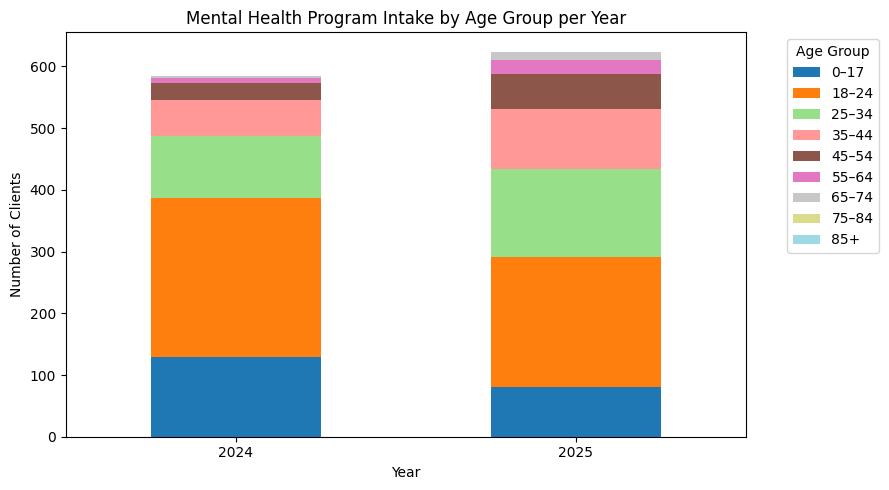

In [62]:
from datetime import datetime

# Compute age from year of birth
current_year = datetime.now().year
df_mental['Age'] = current_year - df_mental['Year of Birth']

# Define age bins and labels
bins = [0, 17, 24, 34, 44, 54, 64, 74, 84, 120]
labels = ['0–17', '18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75–84', '85+']

# Categorize into age groups
df_mental['Age_Group'] = pd.cut(df_mental['Age'], bins=bins, labels=labels, right=True)

# Extract year from intake date
df_mental['Year'] = df_mental['intake_date'].dt.year

# Count number of clients per Year and Age Group
age_year_counts = df_mental.groupby(['Year', 'Age_Group']).size().unstack(fill_value=0)

# Plot stacked bar chart
age_year_counts.plot(kind='bar', stacked=True, figsize=(9,5), colormap='tab20')
plt.title('Mental Health Program Intake by Age Group per Year')
plt.xlabel('Year')
plt.ylabel('Number of Clients')
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## Toronto weather (2024 - 2025)

#### Load the weather data

In [26]:
weather_2024_df = pd.read_csv('../data/toronto-weather/weather-2024-data.csv')
weather_2025_df = pd.read_csv('../data/toronto-weather/weather-2025-data.csv')

#### Prepare the weather data into weekly

In [27]:
def prepare_weekly_weather(df):
    # Convert Date/Time to datetime
    df['Date/Time'] = pd.to_datetime(df['Date/Time'], errors='coerce')
    
    # Keep relevant columns
    df = df[['Date/Time', 'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)',
             'Total Rain (mm)', 'Total Snow (cm)']].copy()
    
    # Add week number and year
    df['Year'] = df['Date/Time'].dt.year
    df['Week'] = df['Date/Time'].dt.isocalendar().week
    
    # Aggregate by week
    weekly_df = df.groupby(['Year', 'Week']).agg({
        'Max Temp (°C)': 'mean',
        'Min Temp (°C)': 'mean',
        'Mean Temp (°C)': 'mean',
        'Total Rain (mm)': 'sum',
        'Total Snow (cm)': 'sum'
    }).reset_index()
    
    return weekly_df

# Prepare weekly weather
weekly_weather_2024 = prepare_weekly_weather(weather_2024_df)
weekly_weather_2025 = prepare_weekly_weather(weather_2025_df)

# Combine 2024 and 2025
weekly_weather_all = pd.concat([weekly_weather_2024, weekly_weather_2025], ignore_index=True)

print(weekly_weather_all.head(10))


   Year  Week  Max Temp (°C)  Min Temp (°C)  Mean Temp (°C)  Total Rain (mm)  \
0  2024     1       1.900000      -2.666667       -0.400000              2.8   
1  2024     2       3.371429      -2.500000        0.442857             39.8   
2  2024     3      -6.300000     -13.142857       -9.757143              0.0   
3  2024     4       2.300000      -0.700000        0.814286             32.6   
4  2024     5       3.757143      -1.914286        0.914286              0.0   
5  2024     6       6.914286      -1.057143        2.957143              0.9   
6  2024     7       0.885714      -6.214286       -2.685714              0.4   
7  2024     8       5.042857      -7.300000       -1.128571              0.0   
8  2024     9       8.600000      -1.771429        3.428571             24.7   
9  2024    10      10.357143       2.257143        6.328571             13.9   

   Total Snow (cm)  
0              4.6  
1             14.8  
2              2.6  
3              5.4  
4             

#### Combine the weekly health data with weekly weather data

In [28]:
# --- For mental health weekly data ---
df_mental_weekly = weekly_counts.reset_index()
df_mental_weekly.columns = ['week_start', 'client_count']

# Extract Year and Week number from week_start
df_mental_weekly['Year'] = df_mental_weekly['week_start'].dt.year
df_mental_weekly['Week'] = df_mental_weekly['week_start'].dt.isocalendar().week

# --- For weather weekly data ---
weekly_weather_all['week_start'] = pd.to_datetime(
    weekly_weather_all['Year'].astype(str) + '-W' + 
    weekly_weather_all['Week'].astype(str) + '-1', 
    format='%Y-W%W-%w'
)

# Filter weather to start from July 2024 (week 27)
weekly_weather_filtered = weekly_weather_all[
    (weekly_weather_all['Year'] > 2024) |
    ((weekly_weather_all['Year'] == 2024) & (weekly_weather_all['Week'] >= 27))
].reset_index(drop=True)


merged_df = pd.merge(df_mental_weekly, weekly_weather_filtered, how='left', on=['Year', 'Week'])

print(merged_df.head())

  week_start_x  client_count  Year  Week  Max Temp (°C)  Min Temp (°C)  \
0   2024-07-15            10  2024    29      26.714286      16.671429   
1   2024-07-22            24  2024    30      27.057143      16.428571   
2   2024-07-29           105  2024    31      29.485714      20.871429   
3   2024-08-05            35  2024    32      24.528571      15.642857   
4   2024-08-12            27  2024    33      26.414286      16.014286   

   Mean Temp (°C)  Total Rain (mm)  Total Snow (cm) week_start_y  
0       21.714286            122.9              0.0   2024-07-15  
1       21.771429             22.6              0.0   2024-07-22  
2       25.200000              8.7              0.0   2024-07-29  
3       20.100000             13.9              0.0   2024-08-05  
4       21.242857            152.7              0.0   2024-08-12  


#### Visualize the number of intake per week vs the average temp per week

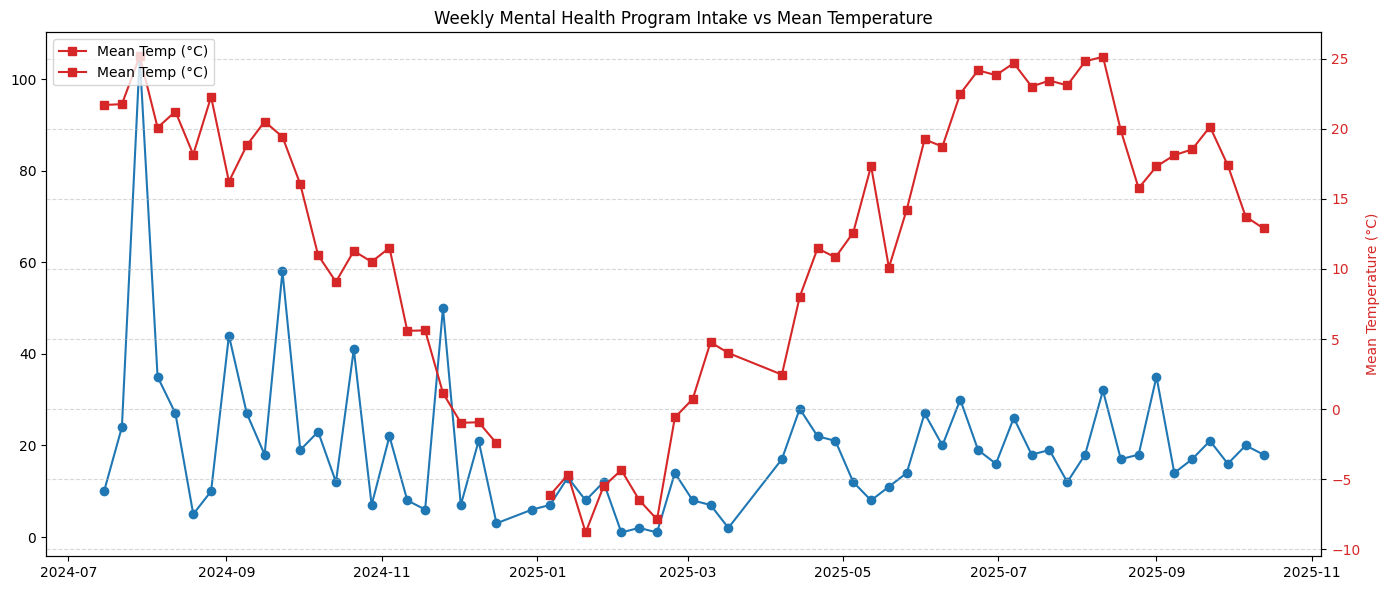

In [75]:
plt.figure(figsize=(14,6))

plt.plot(merged_df['week_start_x'], merged_df['client_count'], marker='o', color='tab:blue', label='Client Count')

ax2 = plt.gca().twinx()
ax2.plot(merged_df['week_start_x'], merged_df['Mean Temp (°C)'], marker='s', color='tab:red', label='Mean Temp (°C)')

plt.title('Weekly Mental Health Program Intake vs Mean Temperature')
plt.xlabel('Week Start')
plt.ylabel('Number of Clients', color='tab:blue')
ax2.set_ylabel('Mean Temperature (°C)', color='tab:red')

plt.gca().tick_params(axis='y', labelcolor='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.grid(True, linestyle='--', alpha=0.5)
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()


## Model train and test 

#### Prepare the dataset

In [29]:
# Ensure week_start is datetime and sort
merged_df['week_start_x'] = pd.to_datetime(merged_df['week_start_x'])
merged_df = merged_df.sort_values('week_start_x')

# Select only client counts
weekly_series = merged_df.set_index('week_start_x')['client_count']

# Split train/test
train = weekly_series['2024-07-01':'2025-07-31']
test = weekly_series['2025-08-01':'2025-10-15']

## ARIMA Model

In [ ]:
# Fit ARIMA
model = ARIMA(train, order=(1,1,1))  # simple starting point
model_fit = model.fit()

# Forecast for test period
forecast = model_fit.forecast(steps=len(test))

/Users/sopheaktralean/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sopheaktralean/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sopheaktralean/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/sopheaktralean/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results w

#### Visualize the training set, the forecast set, and the actual set

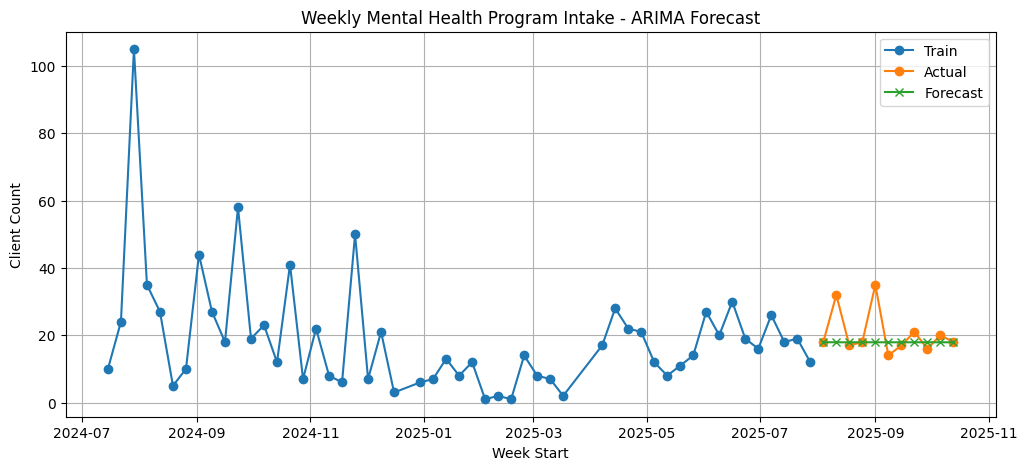

In [31]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train', marker='o')
plt.plot(test.index, test, label='Actual', marker='o')
plt.plot(test.index, forecast, label='Forecast', marker='x')
plt.title('Weekly Mental Health Program Intake - ARIMA Forecast')
plt.xlabel('Week Start')
plt.ylabel('Client Count')
plt.legend()
plt.grid(True)
plt.show()

#### Evaluate the ARIMA model

In [32]:
mae = mean_absolute_error(test, forecast)
rmse = mean_squared_error(test, forecast, squared=False)

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

MAE: 4.02
RMSE: 6.91


/Users/sopheaktralean/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## SARIMAX Model

Training set shape: (47, 3)
Test set shape: (11, 3)

Missing values in training set:
week_start_x      0
client_count      0
Mean Temp (°C)    0
dtype: int64

Missing values in test set:
week_start_x      0
client_count      0
Mean Temp (°C)    0
dtype: int64


/Users/sopheaktralean/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/sopheaktralean/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/sopheaktralean/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sopheaktralean/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWa

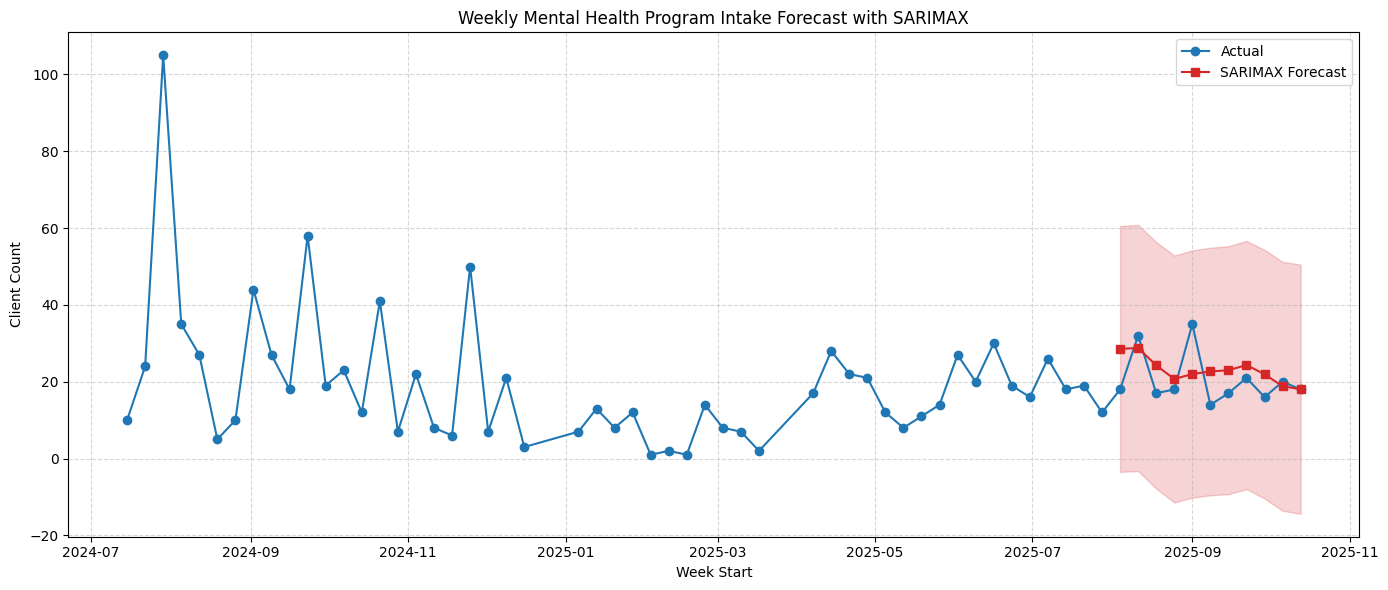


Model Performance:
MAE: 5.63
RMSE: 6.81


In [37]:
# --- Prepare dataset ---
df_sarimax = merged_df[['week_start_x', 'client_count', 'Mean Temp (°C)']].copy()
df_sarimax = df_sarimax.dropna()

# Train-test split
train = df_sarimax[df_sarimax['week_start_x'] < '2025-07-01'].copy()
test  = df_sarimax[df_sarimax['week_start_x'] >= '2025-08-01'].copy()

# Define endogenous (y) and exogenous (X) variables
y_train = train['client_count']
X_train = train[['Mean Temp (°C)']]
y_test  = test['client_count']
X_test  = test[['Mean Temp (°C)']]

# Verify no missing values
print(f"Training set shape: {train.shape}")
print(f"Test set shape: {test.shape}")
print("\nMissing values in training set:")
print(train.isnull().sum())
print("\nMissing values in test set:")
print(test.isnull().sum())

# --- Fit SARIMAX model ---
model = SARIMAX(y_train, exog=X_train, order=(1,0,1), seasonal_order=(0,0,0,0))
results = model.fit(disp=False)  # You were missing this line!

# --- Generate forecast ---
# Get forecast for the test period
forecast_obj = results.get_forecast(steps=len(test), exog=X_test)
forecast = forecast_obj.predicted_mean  # Extract just the predicted values
forecast_ci = forecast_obj.conf_int()   # Get confidence intervals if needed

# --- Plot ---
plt.figure(figsize=(14,6))
plt.plot(df_sarimax['week_start_x'], df_sarimax['client_count'], 
         marker='o', label='Actual', color='tab:blue')
plt.plot(test['week_start_x'], forecast, 
         marker='s', label='SARIMAX Forecast', color='tab:red')

# Optional: Add confidence interval
plt.fill_between(test['week_start_x'], 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 color='tab:red', alpha=0.2)

plt.xlabel('Week Start')
plt.ylabel('Client Count')
plt.title('Weekly Mental Health Program Intake Forecast with SARIMAX')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- Evaluation metrics ---
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, forecast)
rmse = np.sqrt(mean_squared_error(y_test, forecast))
print(f"\nModel Performance:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

## LSTM Model

Total data points: 62
Training set: 51 weeks
Test set: 11 weeks

Training sequences shape: (47, 4, 2)
Test sequences shape: (7, 4, 2)

LSTM MODEL ARCHITECTURE


/Users/sopheaktralean/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 4, 50)          │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,101 (125.39 KB)

 Trainable params: 32,101 (125.39 KB)

 Non-trainable params: 0 (0.00 B)


TRAINING MODEL...
Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0314 - mae: 0.1353 - val_loss: 0.0199 - val_mae: 0.1309
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0288 - mae: 0.1122 - val_loss: 0.0076 - val_mae: 0.0712
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0152 - mae: 0.0829 - val_loss: 0.0028 - val_mae: 0.0446
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0171 - mae: 0.0919 - val_loss: 0.0043 - val_mae: 0.0586
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0122 - mae: 0.0896 - val_loss: 0.0052 - val_mae: 0.0632
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0155 - mae: 0.0978 - val_loss: 0.0044 - val_mae: 0.0586
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0158 - mae: 0.0883 - val_loss: 0.0033 - val_mae: 0.0513
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0132 - mae: 0.0849 - val_loss: 0.0028 - val_mae: 0.0448
Epoch 9/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0

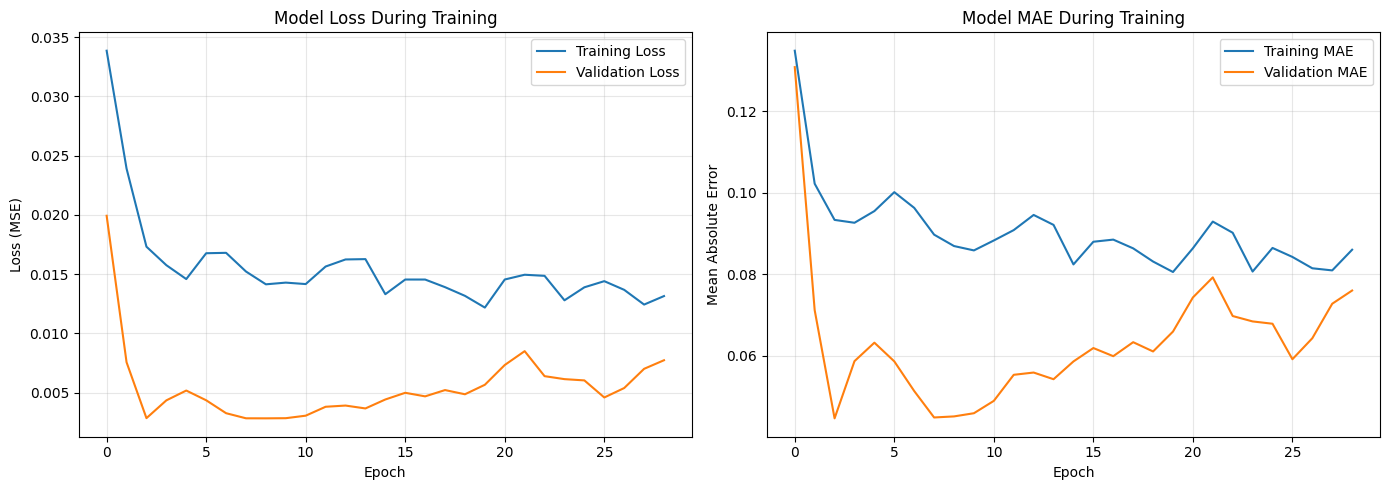

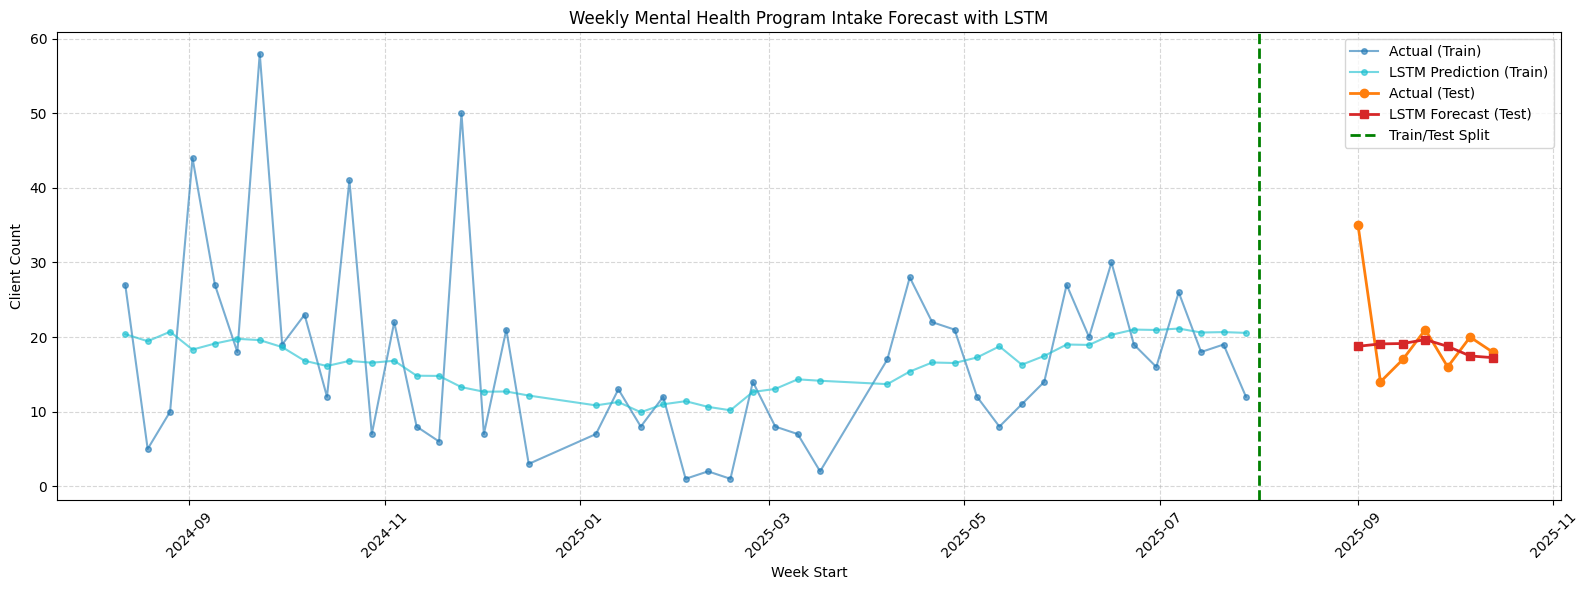

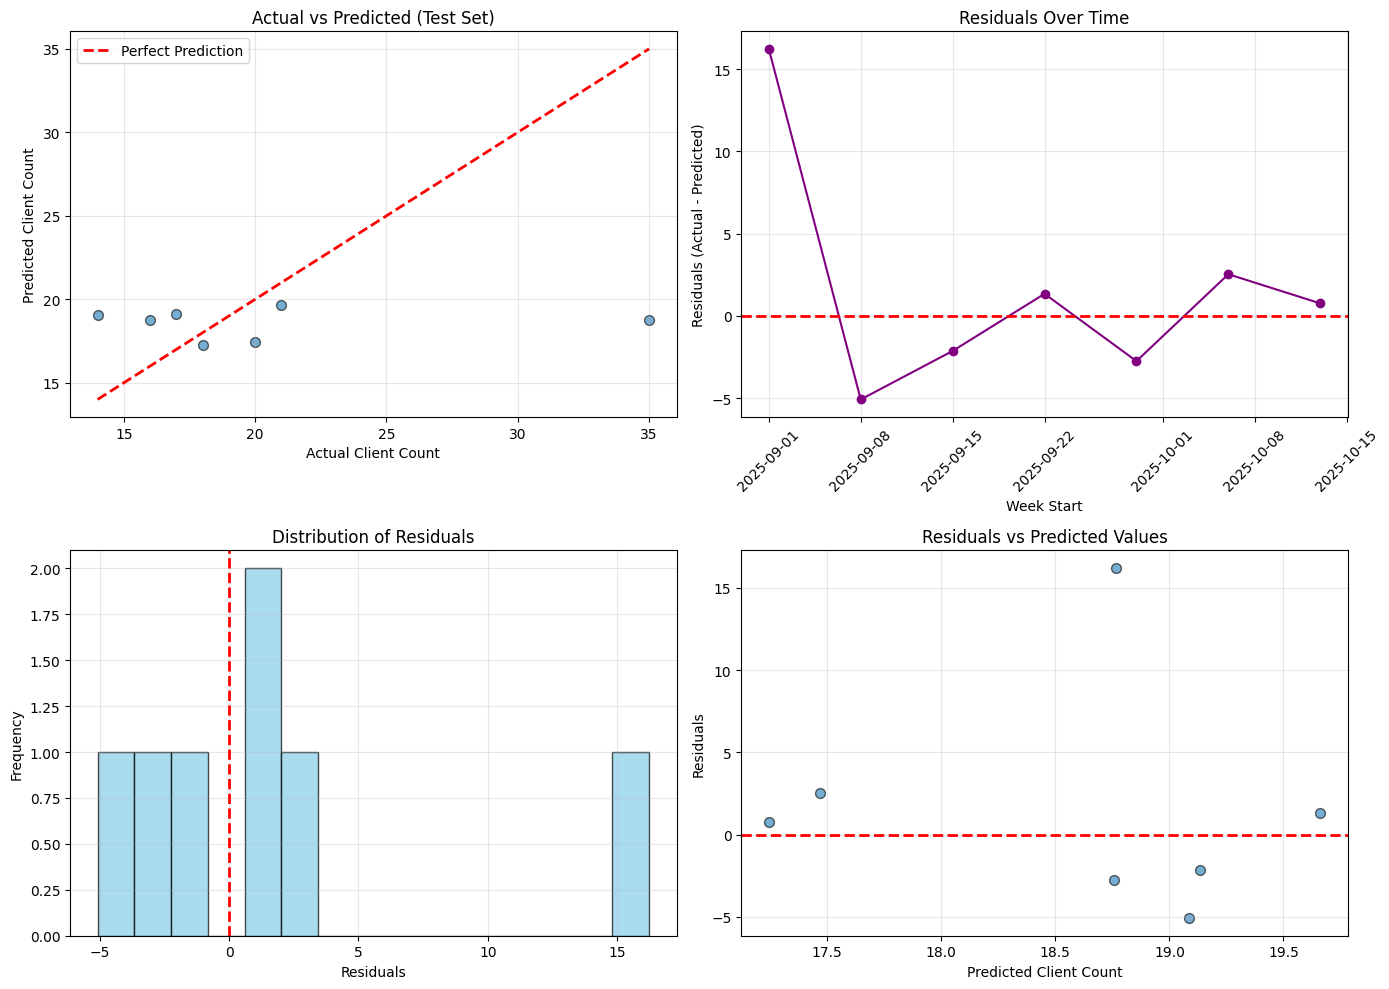


PREDICTION DETAILS
        Week  Actual  Predicted  Residual  Abs Error  % Error
0 2025-09-01    35.0  18.770000     16.23      16.23    46.38
1 2025-09-08    14.0  19.090000     -5.09       5.09    36.32
2 2025-09-15    17.0  19.139999     -2.14       2.14    12.57
3 2025-09-22    21.0  19.660000      1.34       1.34     6.38
4 2025-09-29    16.0  18.760000     -2.76       2.76    17.22
5 2025-10-06    20.0  17.469999      2.53       2.53    12.65
6 2025-10-13    18.0  17.240000      0.76       0.76     4.20

Worst prediction: 16.2 clients off
Best prediction:  0.8 clients off


In [38]:
# --- Prepare dataset ---
df_lstm = merged_df[['week_start_x', 'client_count', 'Mean Temp (°C)']].copy()
df_lstm = df_lstm.dropna()
df_lstm = df_lstm.sort_values('week_start_x').reset_index(drop=True)

print(f"Total data points: {len(df_lstm)}")

# --- Train-test split ---
train = df_lstm[df_lstm['week_start_x'] < '2025-08-01'].copy().reset_index(drop=True)
test = df_lstm[df_lstm['week_start_x'] >= '2025-08-01'].copy().reset_index(drop=True)

print(f"Training set: {len(train)} weeks")
print(f"Test set: {len(test)} weeks")

# --- Scale the data (LSTM works better with normalized data) ---
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_X = MinMaxScaler(feature_range=(0, 1))

# Scale training data
train_y_scaled = scaler_y.fit_transform(train[['client_count']])
train_X_scaled = scaler_X.fit_transform(train[['Mean Temp (°C)']])

# Scale test data
test_y_scaled = scaler_y.transform(test[['client_count']])
test_X_scaled = scaler_X.transform(test[['Mean Temp (°C)']])

# --- Create sequences for LSTM ---
def create_sequences(y_data, X_data, lookback=4):
    """
    Create sequences for LSTM training
    lookback: number of previous time steps to use for prediction
    """
    X_seq, y_seq, X_exog = [], [], []
    
    for i in range(lookback, len(y_data)):
        # Previous 'lookback' weeks of client counts
        X_seq.append(y_data[i-lookback:i, 0])
        # Current week's exogenous variable (temperature)
        X_exog.append(X_data[i, 0])
        # Target: current week's client count
        y_seq.append(y_data[i, 0])
    
    return np.array(X_seq), np.array(X_exog), np.array(y_seq)

# Set lookback period (number of previous weeks to consider)
lookback = 4  # Use past 4 weeks to predict next week

# Create sequences for training
X_train_seq, X_train_exog, y_train_seq = create_sequences(
    train_y_scaled, train_X_scaled, lookback
)

# Create sequences for testing
X_test_seq, X_test_exog, y_test_seq = create_sequences(
    test_y_scaled, test_X_scaled, lookback
)

# Reshape for LSTM input: [samples, timesteps, features]
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1], 1))
X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], X_test_seq.shape[1], 1))

# Combine sequential and exogenous features
X_train_combined = np.concatenate([
    X_train_seq, 
    X_train_exog.reshape(-1, 1, 1).repeat(lookback, axis=1)
], axis=2)

X_test_combined = np.concatenate([
    X_test_seq, 
    X_test_exog.reshape(-1, 1, 1).repeat(lookback, axis=1)
], axis=2)

print(f"\nTraining sequences shape: {X_train_combined.shape}")
print(f"Test sequences shape: {X_test_combined.shape}")

# --- Build LSTM Model ---
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, 
         input_shape=(lookback, 2)),  # 2 features: client_count + temp
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Output layer
])

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Model summary
print("\n" + "="*50)
print("LSTM MODEL ARCHITECTURE")
print("="*50)
model.summary()

# --- Train the model ---
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

print("\n" + "="*50)
print("TRAINING MODEL...")
print("="*50)

history = model.fit(
    X_train_combined, y_train_seq,
    epochs=200,
    batch_size=8,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# --- Make predictions ---
train_predict = model.predict(X_train_combined)
test_predict = model.predict(X_test_combined)

# Inverse transform to get actual values
train_predict = scaler_y.inverse_transform(train_predict)
test_predict = scaler_y.inverse_transform(test_predict)
y_train_actual = scaler_y.inverse_transform(y_train_seq.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))

# --- Evaluation Metrics ---
train_mae = mean_absolute_error(y_train_actual, train_predict)
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
train_r2 = r2_score(y_train_actual, train_predict)

test_mae = mean_absolute_error(y_test_actual, test_predict)
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
test_r2 = r2_score(y_test_actual, test_predict)
test_mape = np.mean(np.abs((y_test_actual - test_predict) / y_test_actual)) * 100

print("\n" + "="*50)
print("MODEL ACCURACY METRICS")
print("="*50)
print("\nTRAINING SET:")
print(f"MAE:   {train_mae:.2f} clients")
print(f"RMSE:  {train_rmse:.2f} clients")
print(f"R²:    {train_r2:.4f}")

print("\nTEST SET:")
print(f"MAE:   {test_mae:.2f} clients")
print(f"RMSE:  {test_rmse:.2f} clients")
print(f"MAPE:  {test_mape:.2f}%")
print(f"R²:    {test_r2:.4f}")
print("="*50)

# Interpretation
print("\nINTERPRETATION:")
print(f"- On average, predictions are off by {test_mae:.1f} clients")
print(f"- The model explains {test_r2*100:.1f}% of variance in client count")
if test_mape < 10:
    print(f"- MAPE of {test_mape:.1f}% indicates EXCELLENT accuracy")
elif test_mape < 20:
    print(f"- MAPE of {test_mape:.1f}% indicates GOOD accuracy")
elif test_mape < 30:
    print(f"- MAPE of {test_mape:.1f}% indicates REASONABLE accuracy")
else:
    print(f"- MAPE of {test_mape:.1f}% indicates POOR accuracy")

# --- Plot Training History ---
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss During Training')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Model MAE During Training')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Plot Predictions ---
plt.figure(figsize=(16, 6))

# Get the dates for plotting (accounting for lookback)
train_dates = train['week_start_x'].iloc[lookback:].values
test_dates = test['week_start_x'].iloc[lookback:].values

plt.plot(train_dates, y_train_actual, marker='o', 
         label='Actual (Train)', color='tab:blue', alpha=0.6, markersize=4)
plt.plot(train_dates, train_predict, marker='o', 
         label='LSTM Prediction (Train)', color='tab:cyan', alpha=0.6, markersize=4)
plt.plot(test_dates, y_test_actual, marker='o', 
         label='Actual (Test)', color='tab:orange', linewidth=2, markersize=6)
plt.plot(test_dates, test_predict, marker='s', 
         label='LSTM Forecast (Test)', color='tab:red', linewidth=2, markersize=6)

plt.axvline(x=pd.to_datetime('2025-08-01'), color='green', 
            linestyle='--', linewidth=2, label='Train/Test Split')
plt.xlabel('Week Start')
plt.ylabel('Client Count')
plt.title('Weekly Mental Health Program Intake Forecast with LSTM')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Residual Analysis ---
residuals = y_test_actual.flatten() - test_predict.flatten()

plt.figure(figsize=(14, 10))

# 1. Actual vs Predicted
plt.subplot(2, 2, 1)
plt.scatter(y_test_actual, test_predict, alpha=0.6, edgecolors='k', s=50)
plt.plot([y_test_actual.min(), y_test_actual.max()], 
         [y_test_actual.min(), y_test_actual.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Client Count')
plt.ylabel('Predicted Client Count')
plt.title('Actual vs Predicted (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Residuals over time
plt.subplot(2, 2, 2)
plt.plot(test_dates, residuals, marker='o', linestyle='-', color='purple')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Week Start')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals Over Time')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 3. Residuals distribution
plt.subplot(2, 2, 3)
plt.hist(residuals, bins=15, edgecolor='black', alpha=0.7, color='skyblue')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)

# 4. Residuals vs Predicted
plt.subplot(2, 2, 4)
plt.scatter(test_predict, residuals, alpha=0.6, edgecolors='k', s=50)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Client Count')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Prediction Summary Table ---
summary_df = pd.DataFrame({
    'Week': test_dates,
    'Actual': y_test_actual.flatten(),
    'Predicted': test_predict.flatten(),
    'Residual': residuals,
    'Abs Error': np.abs(residuals),
    '% Error': np.abs(residuals / y_test_actual.flatten()) * 100
})

print("\n" + "="*50)
print("PREDICTION DETAILS")
print("="*50)
print(summary_df.round(2))
print(f"\nWorst prediction: {summary_df['Abs Error'].max():.1f} clients off")
print(f"Best prediction:  {summary_df['Abs Error'].min():.1f} clients off")

# --- Save the model (optional) ---
# model.save('lstm_mental_health_forecast.h5')
# print("\nModel saved as 'lstm_mental_health_forecast.h5'")